# Rethinking Statistics course in Stan - Week 2

Lecture 3: Geocentric Models

- [Video](https://youtu.be/h5aPo5wXN8E)
- [Slides](https://speakerdeck.com/rmcelreath/l03-statistical-rethinking-winter-2019)

Lecture 4: Wiggly Orbits

- [Video](https://youtu.be/ENxTrFf9a7c)
- [Slides](https://speakerdeck.com/rmcelreath/l04-statistical-rethinking-winter-2019)

[Proposed problems](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week02.pdf) and [solutions in R](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week02_solutions.pdf) for the exercises of the week.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from cmdstanpy import CmdStanModel
from plotnine import *

In [2]:
%load_ext watermark
%watermark -n -u -p pandas,numpy,cmdstanpy,plotnine,scipy

Last updated: Fri Dec 31 2021

pandas   : 1.3.4
numpy    : 1.21.4
cmdstanpy: 1.0.0
plotnine : 0.8.0
scipy    : 1.7.3



## Short Intro

Example of building a prior manually (kind of a pain):

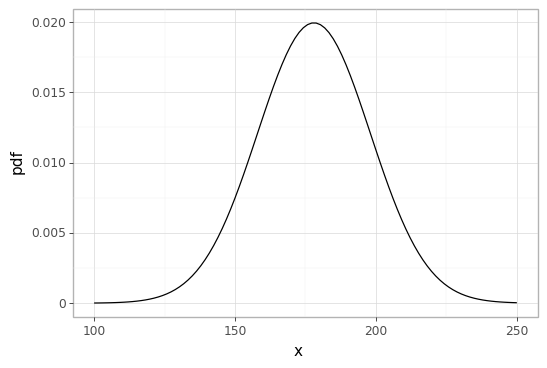

<ggplot: (8770265295613)>

In [3]:
x = np.linspace(100, 250, 100)
pdf = stats.norm.pdf(x, 178, 20)
data = pd.DataFrame({'x':x, 'pdf':pdf})

(
    ggplot(data)
    + aes(x='x', y='pdf')
    + geom_line()
    + theme_light()
    + theme(figure_size=(6,4))
)

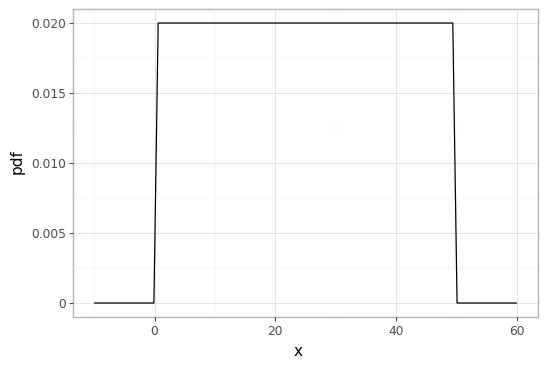

<ggplot: (8770265299131)>

In [4]:
x = np.linspace(-10, 60, 100)
pdf = stats.uniform.pdf(x, 0, 50)
data = pd.DataFrame({'x':x, 'pdf':pdf})

(
    ggplot(data)
    + aes(x='x', y='pdf')
    + geom_line()
    + theme_light()
    + theme(figure_size=(6,4))
)

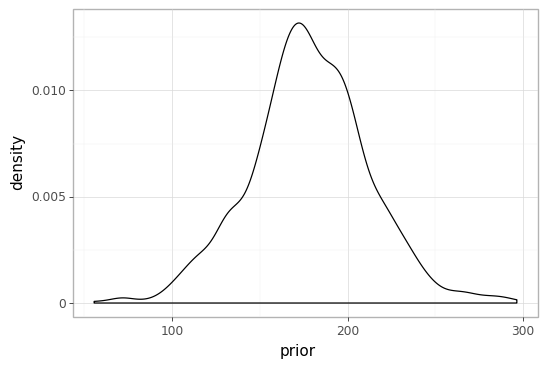

<ggplot: (8770263055514)>

In [5]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
data = pd.DataFrame({'prior':prior_h})

(
    ggplot(data)
    + aes(x='prior')
    + geom_density()
    + theme_light()
    + theme(figure_size=(6,4))
)

## Exercise 1

>The weights listed below were recorded in the !Kung census, but heights were not recorded for the weights 45, 40, 65, 31 and 53. Provide predicted heights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

In [6]:
d = pd.read_csv('./dat/Howell1.csv', sep=';', header=0)
d.tail(3)

,height,weight,age,male
541,156.21,54.062497,21.0,0
542,71.12,8.051258,0.0,1
543,158.75,52.531624,68.0,1


In [7]:
aux = (pd.DataFrame(np.array([45, 40, 65, 31, 53]))
       .rename(columns={0:'weight'})
       .assign(height_hat=np.nan)
      )
aux

,weight,height_hat
0,45,NaN
1,40,NaN
2,65,NaN
3,31,NaN
4,53,NaN


Let's get the data. The weights that interest us are all adult weights, so we can analyze only the adults and make a linear approximation.

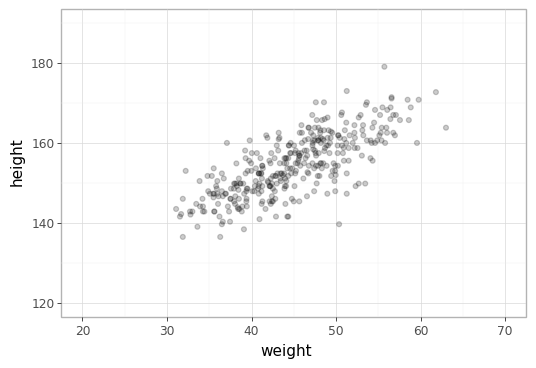

<ggplot: (8770263004745)>

In [8]:
d1 = d.loc[d.age>=18].reset_index(drop=True)

(
    ggplot(d1)
    + aes(x='weight', y='height')
    + geom_point(alpha=0.2)
    + theme_light()
    + xlim(20,70)
    + ylim(120,190)
    + theme(figure_size=(6,4))
)

This is the first of many times that a model is defined so I'll take a moment to explain a bit its general structure. First the model is defined and named, in this case as `model`. Then there are four basic sections within it:

1. **Data**: where the data that model needs is defined. Usually, the data is divided in two sets: one for fitting the model ($X_{train}$) and other one for testing it ($X_{test}$). This is very useful for making predictions with the model for data not used for its fitting, something extremely common in Machine Learning. In the course and the book this is usually called out-of-sample prediction but in general Data Science we refer to it as just measuring the accuracy of the model on the test set.

2. **Priors**: where the priors are defined. This priors are the initial distributions our parameters evolve from. They are supposed to represent our knowledge about our system. For instance, a standard deviation can not be negative so we initialize it as a Uniform distribution with lower bound zero. In the course this is mentioned again and again.

3. **Likelihood**: where we define the actual structure of the model, in this case a linear regression (to estimate $\mu$). We also define the output variable, in this case `height_hat`. The "hat" subindex in the output metric of almost all models to express that it is the model estimation of the original variable, in this case `height`.

4. **Prior, trace and posterior**: where the priors are sampled from and where the posteriors are estimated and sampled from. Most of the time we will not need neither the priors or the posterior predictions only the parameters, that are stored in the trace. However, it is a good policy to have in all models to keep all concepts in mind.

In [9]:
weight_code = '''

data {
    int<lower=1> n;           // number of observations
    vector[n] weight;  
    vector[n] height;
    int<lower=1> p;           // number of posterior predictions check
    vector[p] weight_ppc;
}

parameters {
    real alpha;               // intercept
    real beta;                // slope
    real<lower=0> sigma;      // scatter
}

transformed parameters {
    // Any variable declared here is part of the output produced for draws.
    vector[n] mu;             // location
    mu = alpha + beta * weight;
}

model {
    // priors
    alpha ~ normal(178, 20);  // prior for intercept
    beta ~ normal(0, 10);     // prior for scale
    sigma ~ normal(0, 50);    // prior for scatter
    // likelihood
    height ~ normal(mu, sigma);
}

generated quantities {
    vector[p] height_ppc;
    for (i in 1:p) {height_ppc[i] = normal_rng(mu[i], sigma);}
}
'''

stan_file = './stn/week02_ex01.stan'
with open(stan_file, 'w') as f:
    print(weight_code, file=f)
    
stan_model = CmdStanModel(stan_file=stan_file)
stan_model.compile()

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week02_ex01.stan to exe file /home/jovyan/work/statret/stn/week02_ex01
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week02_ex01
INFO:cmdstanpy:found newer exe file, not recompiling


In [10]:
%%time
data = d1[['height', 'weight']].to_dict(orient='list')
data['n'] = len(data['weight'])
data['weight_ppc'] = d1.weight.to_list()
data['p'] = len(data['weight_ppc'])
stan_fit = stan_model.sample(data=data, chains=4)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



CPU times: user 483 ms, sys: 154 ms, total: 636 ms
Wall time: 1.75 s


Let's get summaries using the method `summary`. It returns a Pandas dataframe containning summary statistics of all the defined parameters. However, we are only interested in `alpha`, `beta` and `sigma`. They are selected using dataframe row selection.

In [11]:
stan_fit.summary().loc[['alpha','beta','sigma']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha,110.00,0.0560,1.900,110.00,110.00,120.00,1100.0,310.0,1.0
beta,0.89,0.0013,0.041,0.83,0.89,0.96,1100.0,300.0,1.0
sigma,5.10,0.0045,0.190,4.80,5.10,5.40,1800.0,490.0,1.0


Let's get a predicted value for each of our original samples. This is not requested by the exercise but I think it makes sense first to estimate how good our predictions are in-sample (or in $X_{train}$) before moving to doing predictions out-of-sample ($X_{test}$). Let's just take the mean for each original sample and build a new column for it in the original dataset.

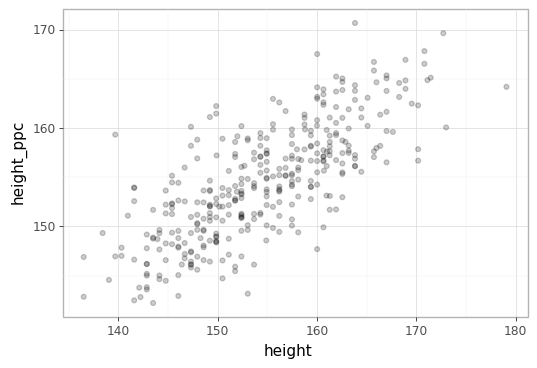

<ggplot: (8770263087147)>

In [12]:
d1['height_ppc'] = stan_fit.stan_variable(var='height_ppc').mean(axis=0)
(
    ggplot(d1)
    + aes(x='height', y='height_ppc')
    + geom_point(alpha=0.2)
    + theme_light()
    + theme(figure_size=(6,4))
)

In [13]:
mse = ((d1.height - d1.height_ppc)**2).mean(axis=0)
print(f'The RMSE in X_train is {np.sqrt(mse):.2f} cm.')

The RMSE in X_train is 5.07 cm.


I think thats a reasonably good RMSE. Let's build now the High Posterior Density Interval for each original sample.

In [14]:
smry = stan_fit.summary(percentiles=[5,95])
rows = [row for row in smry.index if 'height_ppc' in row]
smry = smry.loc[rows]
smry.tail(3)

,Mean,MCSE,StdDev,5%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,
height_ppc[350],161.0,0.084,5.2,152.0,170.0,3868.0,1070.0,1.0
height_ppc[351],163.0,0.080,5.1,154.0,171.0,4109.0,1137.0,1.0
height_ppc[352],161.0,0.088,5.1,153.0,170.0,3340.0,924.0,1.0


Let's finally predict the values requested by the exercise. In this case we had two inputs: `weight` and `height` but actually only have information regarding `weight` for our new individuals so we only update this variable. 

In [15]:
%%time
data = d1[['height', 'weight']].to_dict(orient='list')
data['n'] = len(d1.weight)
data['weight_ppc'] = aux.weight.to_list()
data['p'] = len(aux.weight.values)
stan_fit = stan_model.sample(data=data, chains=4)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



CPU times: user 316 ms, sys: 171 ms, total: 487 ms
Wall time: 1.28 s


In [16]:
smry = stan_fit.summary(percentiles=[5,95])
rows = [row for row in smry.index if 'height_ppc' in row]
smry = smry.loc[rows]
smry

,Mean,MCSE,StdDev,5%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,
height_ppc[1],157.0,0.082,5.1,149.0,165.0,3776.0,1516.0,1.0
height_ppc[2],147.0,0.080,5.1,139.0,155.0,4075.0,1637.0,1.0
height_ppc[3],143.0,0.083,5.2,134.0,151.0,3837.0,1541.0,1.0
height_ppc[4],162.0,0.083,5.1,154.0,170.0,3755.0,1508.0,1.0
height_ppc[5],151.0,0.080,5.2,143.0,160.0,4150.0,1667.0,1.0


## Exercise 2

>Model the relationship between `height` (cm) and the natural logarithm of weight (log-kg): `log(weight)`. Use the entire `Howell1` data frame, all 544 rows, adults and non-adults. Use any model type from Chapter 4 (from the book) that you think useful: an ordinary linear regression, a polynomial or a spline. Plot the posterior predictions against the raw data.

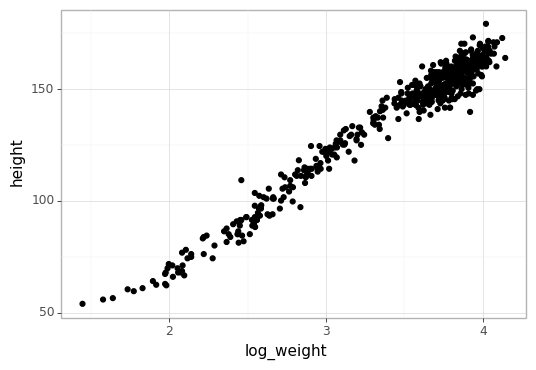

<ggplot: (8770263023951)>

In [17]:
d2 = d.assign(log_weight = np.log(d.weight))

(
    ggplot(d2)
    + aes(x='log_weight', y='height')
    + geom_point()
    + theme_light()
    + theme(figure_size=(6,4))
)

In [18]:
weight_code = '''

data {
    int<lower=1> n;           // number of observations
    vector[n] log_weight;  
    vector[n] height;
}

parameters {
    real alpha;               // intercept
    real beta;                // slope
    real<lower=0> sigma;      // scatter
}

transformed parameters {
    vector[n] mu;             // location
    mu = alpha + beta * log_weight;
}

model {
    // priors
    alpha ~ normal(178, 20);  // prior for intercept
    beta ~ normal(0, 1);      // prior for scale
    sigma ~ normal(0, 50);    // prior for scatter
    // likelihood
    height ~ normal(mu, sigma);
}

generated quantities {
    vector[n] height_ppc;
    for (i in 1:n) {height_ppc[i] = normal_rng(mu[i], sigma);}
}

'''

stan_file = './stn/week02_ex02a.stan'
with open(stan_file, 'w') as f:
    print(weight_code, file=f)

stan_model = CmdStanModel(stan_file=stan_file)
stan_model.compile()

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week02_ex02a.stan to exe file /home/jovyan/work/statret/stn/week02_ex02a
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week02_ex02a
INFO:cmdstanpy:found newer exe file, not recompiling


In [19]:
%%time
data = d2[['height', 'log_weight']].to_dict(orient='list')
data['n'] = len(data['log_weight'])
stan_fit = stan_model.sample(data=data, chains=4)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



CPU times: user 521 ms, sys: 142 ms, total: 663 ms
Wall time: 2.19 s


In [20]:
stan_fit.summary().loc[['alpha','beta','sigma']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha,88.0,0.140,4.40,80.0,88.0,95.0,960.0,200.0,1.0
beta,15.0,0.040,1.20,13.0,15.0,17.0,950.0,200.0,1.0
sigma,19.0,0.029,0.95,18.0,19.0,21.0,1000.0,220.0,1.0


Just as the previous exercise, we recover the mean of height_hat for each sample and the High Posterior Density interval for each sample as well.

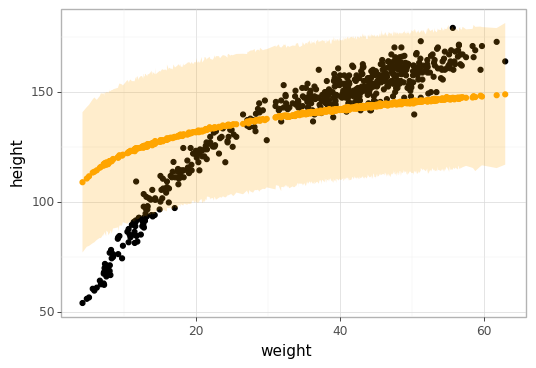

<ggplot: (8770372755188)>

In [21]:
im = d2[['weight', 'height']].copy()
height_ppc = stan_fit.stan_variable(var='height_ppc')
im['height_ppc'] = height_ppc.mean(axis=0)
im['height_ppc_5'] = np.percentile(height_ppc, 5, axis=0)
im['height_ppc_95'] = np.percentile(height_ppc, 95, axis=0)

(
    ggplot(im)
    + geom_point(aes(x='weight', y='height'))
    + geom_point(aes(x='weight', y='height_ppc'), color='orange')
    + geom_ribbon(aes(x='weight', ymin='height_ppc_5', ymax='height_ppc_95'), alpha=0.2, fill = 'orange')
    + theme_light()
    + theme(figure_size=(6,4))
)

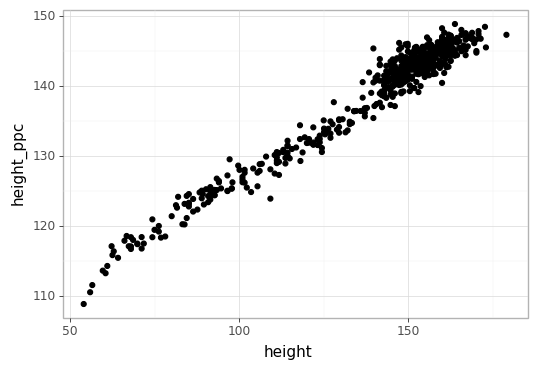

<ggplot: (8770372727290)>

In [22]:
im = d2[['weight', 'height']].copy()
height_ppc = stan_fit.stan_variable(var='height_ppc')
im['height_ppc'] = height_ppc.mean(axis=0)

(
    ggplot(im)
    + aes(x='height', y='height_ppc')
    + geom_point()
    + theme_light()
    + theme(figure_size=(6,4))
) 

Results are meh. Let's see what happens when we take a polynomial regression of second degree.

In [23]:
d2['weight_2'] = d2.weight**2
d2.head(3)

,height,weight,age,male,log_weight,weight_2
0,151.765,47.825606,63.0,1,3.867561,2287.288637
1,139.700,36.485807,63.0,0,3.596923,1331.214076
2,136.525,31.864838,65.0,0,3.461503,1015.367901


In [24]:
weight_code = '''

    data {
        int n;
        vector[n] height;
        vector[n] weight;
    }
    
    parameters {
        real alpha;
        real beta1;
        real beta2;
        real sigma;
    }
    
    transformed parameters {
        vector[n] mu;
        mu = alpha + beta1 * weight + beta2 * pow(weight,2);
    }
    
    model {
        // priors
        alpha ~ normal(178,20);
        beta1 ~ normal(0,1);
        beta2 ~ normal(0,1);
        sigma ~ normal(0,50);
        // likelihood
        height ~ normal(mu, sigma);
    }
    
    generated quantities {
        vector[n] height_ppc;
        for (i in 1:n) {height_ppc[i] = normal_rng(mu[i], sigma);}
    }

'''

stan_file = './stn/week02_ex02b.stan'
with open(stan_file, 'w') as f:
    print(weight_code, file=f)

stan_model = CmdStanModel(stan_file=stan_file)
stan_model.compile()

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week02_ex02b.stan to exe file /home/jovyan/work/statret/stn/week02_ex02b
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week02_ex02b
INFO:cmdstanpy:found newer exe file, not recompiling


In [25]:
%%time
data = d2[['height', 'weight']].to_dict(orient='list')
data['n'] = len(data['weight'])
stan_fit = stan_model.sample(data=data, chains=4)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



CPU times: user 587 ms, sys: 124 ms, total: 711 ms
Wall time: 7.34 s


In [26]:
stan_fit.summary().loc[['alpha','beta1','beta2','sigma']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha,46.000,0.035000,1.2000,44.00,46.000,48.000,1200.0,88.0,1.0
beta1,4.200,0.002500,0.0850,4.00,4.200,4.300,1200.0,85.0,1.0
beta2,-0.038,0.000037,0.0013,-0.04,-0.038,-0.036,1300.0,91.0,1.0
sigma,5.800,0.004700,0.1700,5.50,5.800,6.100,1300.0,97.0,1.0


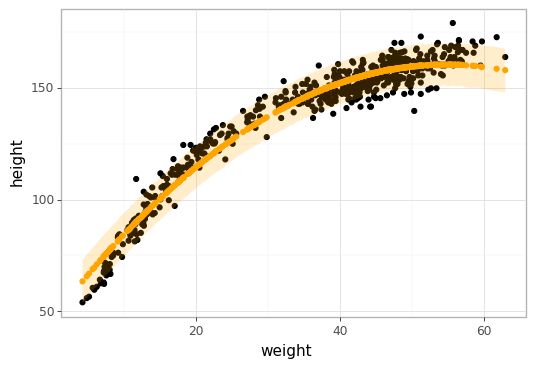

<ggplot: (8770373449635)>

In [27]:
im = d2[['weight', 'height']].copy()
height_ppc = stan_fit.stan_variable(var='height_ppc')
im['height_ppc'] = height_ppc.mean(axis=0)
im['height_ppc_5'] = np.percentile(height_ppc, 5, axis=0)
im['height_ppc_95'] = np.percentile(height_ppc, 95, axis=0)

(
    ggplot(im)
    + geom_point(aes(x='weight', y='height'))
    + geom_point(aes(x='weight', y='height_ppc'), color='orange')
    + geom_ribbon(aes(x='weight', ymin='height_ppc_5', ymax='height_ppc_95'), alpha=0.2, fill = 'orange')
    + theme_light()
    + theme(figure_size=(6,4))
)

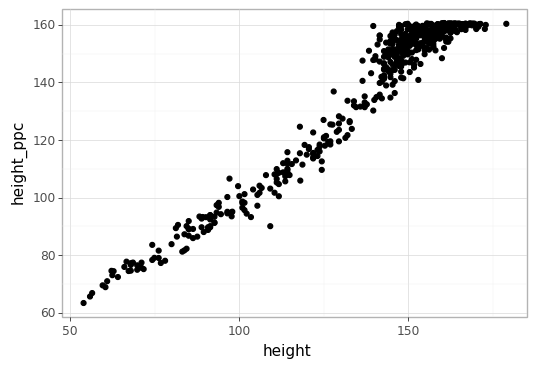

<ggplot: (8770263080671)>

In [28]:
im = d2[['weight', 'height']].copy()
height_ppc = stan_fit.stan_variable(var='height_ppc')
im['height_ppc'] = height_ppc.mean(axis=0)

(
    ggplot(im)
    + aes(x='height', y='height_ppc')
    + geom_point()
    + theme_light()
    + theme(figure_size=(6,4))
) 

Much better now.

## Exercise 3

> Plot the prior predictive distribution for the polynomial regression model in Chapter 4 (_just what we did in the previous exercise_). You can modify the the code that plots the linear regression prior predictive distribution. 20 or 30 parabolas from the prior should suffice to show where the prior probability resides. Can you modify the prior distributions of `alpha`, `beta1`, and `beta2` so that the prior predictions stay within the biologically reasonable outcome space? That is to say: Do not try to fit the data by hand. But do try to keep the curves consistent with what you know about height and weight, before seeing these exact data.

In [29]:
d3 = d2

In [30]:
weight_prior_code = '''

    data {
        int n;
        vector[n] weight;
    }
    
    generated quantities {
        // priors
        real alpha = normal_rng(178,20);
        real beta1 = normal_rng(0,1);
        real beta2 = normal_rng(0,1);
        real sigma = normal_rng(0,50);
        // likelihood
        vector[n] mu;
        vector[n] height_prior;
        mu = alpha + beta1 * weight + beta2 * pow(weight,2);
        for (i in 1:n) {height_prior[i] = normal_rng(mu[i], sigma);}
    }

'''

stan_file = './stn/week02_ex03a.stan'
with open(stan_file, 'w') as f:
    print(weight_prior_code, file=f)

stan_model = CmdStanModel(stan_file=stan_file)
stan_model.compile()

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week02_ex03a.stan to exe file /home/jovyan/work/statret/stn/week02_ex03a
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week02_ex03a
INFO:cmdstanpy:found newer exe file, not recompiling


In [31]:
%%time
data = d3[['weight']].to_dict(orient='list')
data['n'] = len(data['weight'])
stan_fit = stan_model.sample(data=data, chains=4)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



CPU times: user 520 ms, sys: 227 ms, total: 748 ms
Wall time: 1.3 s


Let's just recover the values from the priors manually and build a pandas dataframe.

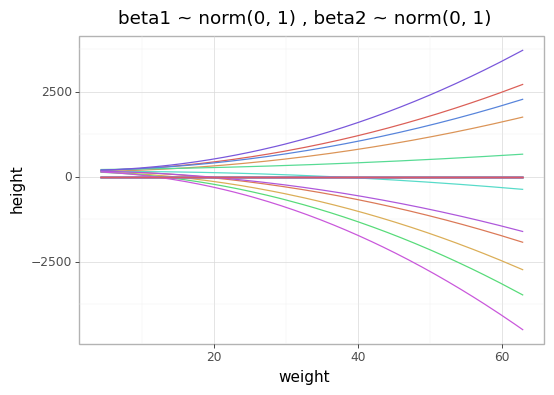

<ggplot: (8770372676840)>

In [32]:
# priors

atts = ['alpha', 'beta1', 'beta2', 'sigma']
df = stan_fit.draws_pd(vars=atts).dropna().reset_index(drop=True)
priors = pd.DataFrame()
for i in range(30):
    priors['prior_'+str(i)] = df.loc[i,'alpha'] + df.loc[i,'beta1'] * d3['weight'] + df.loc[i,'beta2'] * d3['weight']**2

aux = pd.concat([d3.weight, priors], axis=1)
aux_plot = aux.melt(id_vars=['weight'],
                  value_vars=list(aux.columns)[1:],
                  var_name='prior',
                  value_name='height')

(
    ggplot(aux_plot)
    + aes(x='weight', y='height', color='prior')
    + geom_line(show_legend=False)
    + labs(title='beta1 ~ norm(0, 1) , beta2 ~ norm(0, 1)')
    + theme_light()
    + theme(figure_size=(6,4))
)

Recall that the world's tallest person was 270 cm tall. The prior curvature has silly shapes. That can't be right. The basic problem is that `beta2` needs to be negative to make the curve bend down, but `beta1` has to also change in order to move the maximum height to the right. It's all a bit confusing, and is they key reason that working with polynomial models is so hard. The prior on the right below can only bend down, but I've made the linear model `a + beta1 * weight_c - beta2 * weight_c_2` and given `beta1`, `beta2` a logNormal prior.

In [33]:
d3 = d
d3 = d3.assign(weight=pd.Series(d3.weight - d3.weight.mean())/d3.weight.std())

In [34]:
weight_prior_code = '''

    data {
        int n;
        vector[n] weight;
    }
    
    generated quantities {
        // priors
        real alpha = normal_rng(178,20);
        real beta1 = lognormal_rng(2,1);
        real beta2 = lognormal_rng(1,1);
        real sigma = normal_rng(0,50);
        // likelihood
        vector[n] mu;
        vector[n] height_prior;
        mu = alpha + beta1 * weight - beta2 * pow(weight,2);
        for (i in 1:n) {height_prior[i] = normal_rng(mu[i], sigma);}
    }

'''

stan_file = './stn/week02_ex03b.stan'
with open('./stn/week02_ex03b.stan', 'w') as f:
    print(weight_prior_code, file=f)


stan_model = CmdStanModel(stan_file=stan_file)
stan_model.compile()

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week02_ex03b.stan to exe file /home/jovyan/work/statret/stn/week02_ex03b
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week02_ex03b
INFO:cmdstanpy:found newer exe file, not recompiling


In [35]:
%%time
data = d3[['weight']].to_dict(orient='list')
data['n'] = len(data['weight'])
stan_fit = stan_model.sample(data=data, chains=4)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



CPU times: user 571 ms, sys: 186 ms, total: 757 ms
Wall time: 1.24 s


In [36]:
stan_fit.summary().loc[['alpha','beta1','beta2','sigma']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha,88.0,1.40,90.0,0.0,0.0,200.0,4000.0,1400.0,1.0
beta1,6.0,0.19,12.0,0.0,0.0,25.0,4000.0,1400.0,1.0
beta2,2.3,0.10,6.5,0.0,0.0,10.0,4000.0,1400.0,1.0
sigma,19.0,0.44,28.0,0.0,0.0,79.0,4300.0,1400.0,1.0


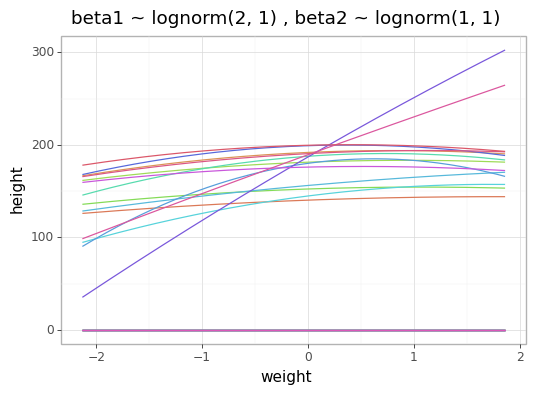

<ggplot: (8770367708106)>

In [37]:
# priors

atts = ['alpha', 'beta1', 'beta2', 'sigma']
df = stan_fit.draws_pd(vars=atts).dropna().reset_index(drop=True)
priors = pd.DataFrame()
for i in range(30):
    priors['prior_'+str(i)] = df.loc[i,'alpha'] + df.loc[i,'beta1'] * d3['weight'] - df.loc[i,'beta2'] * d3['weight']**2

aux = pd.concat([d3.weight, priors], axis=1)
aux_plot = aux.melt(id_vars=['weight'],
                  value_vars=list(aux.columns)[1:],
                  var_name='prior',
                  value_name='height')

(
    ggplot(aux_plot)
    + aes(x='weight', y='height', color='prior')
    + geom_line(show_legend=False)
    + labs(title='beta1 ~ lognorm(2, 1) , beta2 ~ lognorm(1, 1)')
    + theme_light()
    + theme(figure_size=(6,4))
)

A key problem in getting reasonable curves here is that obviously a and `beta1` and `beta2` are correlated in the family of reasonable curves. But the priors are uncorrelated, they are independent of one another. Still, if you can get independent priors to at least live within some reasonably space of outcome values, that's a lot better than flat priors. This is a general phenomenon with “flat” priors: Once the predictor is at all complicated, “flat” does not imply “no relationship.” Do any of the priors above make a difference for inference in this sample? No. There is a lot of data and the model is quite simple, in terms of the way that parameters relate to predictions. This will not always be the case.